<a href="https://colab.research.google.com/github/nuirat/udemy/blob/app_theme/PL_Palestinian_License_Plate_Recognition_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detect Plate


In [1]:
!sudo pip3 install keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/data/data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

In [ ]:
import cv2
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [ ]:
plate_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/data/indian_license_plate.xml')

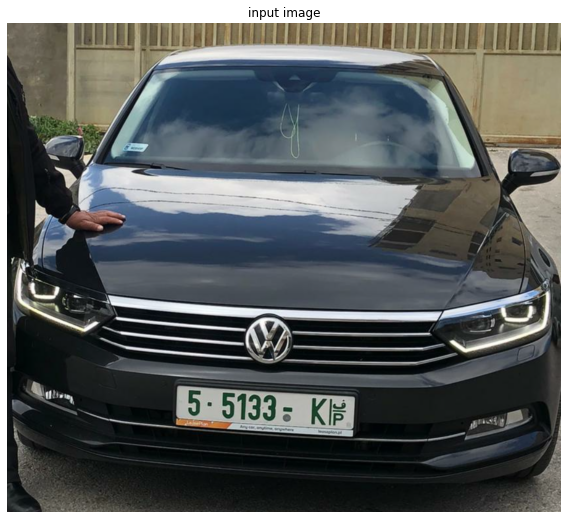

In [ ]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(15,9))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('/content/drive/MyDrive/data/img/200.png')
display(img, 'input image')

In [ ]:
images_dir = "/content/drive/MyDrive/data/img/"
image_files = os.listdir(images_dir)

In [ ]:
image_path = "{}/{}".format(images_dir, "200.png")

In [ ]:
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)

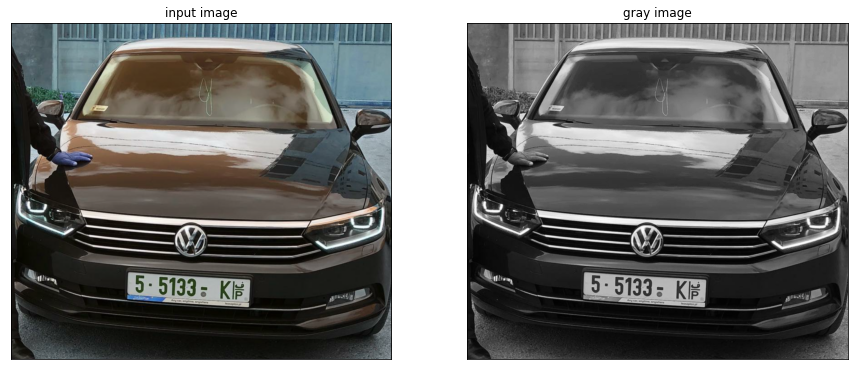

In [ ]:
plot_images(image, gray,'input image','gray image')

In [ ]:
blur = cv2.bilateralFilter(gray, 11,90, 90)

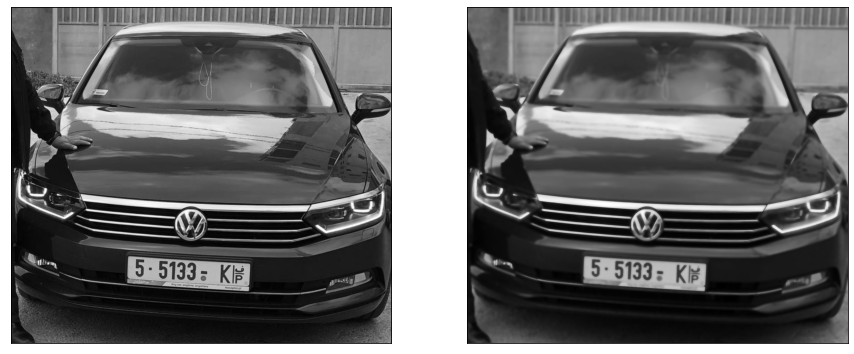

In [ ]:
plot_images(gray, blur)

In [ ]:
edges = cv2.Canny(blur, 30, 200)

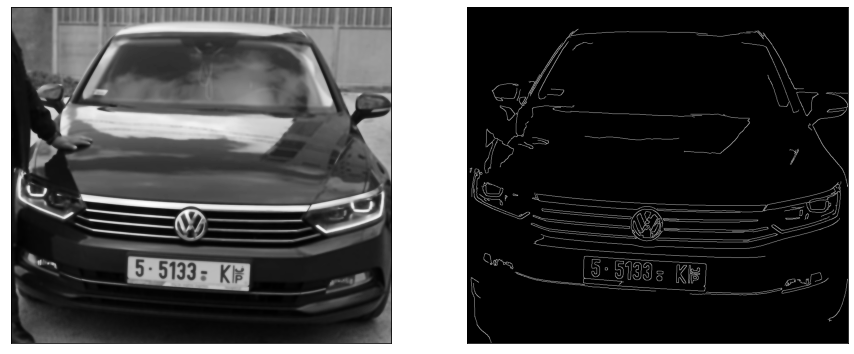

In [ ]:
plot_images(blur, edges)

In [ ]:
cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
image_copy = image.copy()

In [ ]:
_ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)

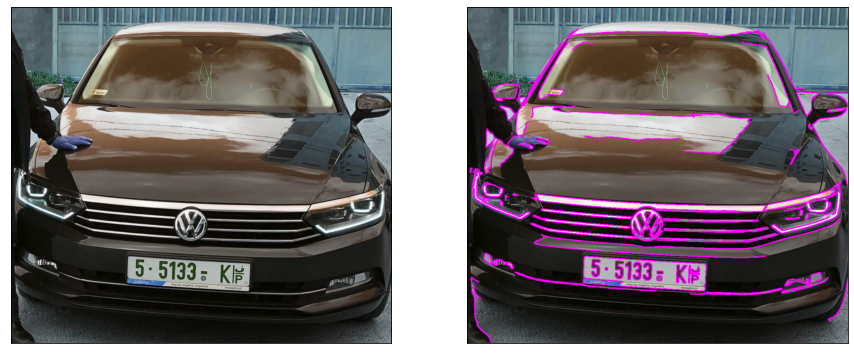

In [ ]:
plot_images(image, image_copy)

In [ ]:
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]

In [ ]:
image_copy = image.copy()
_ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)

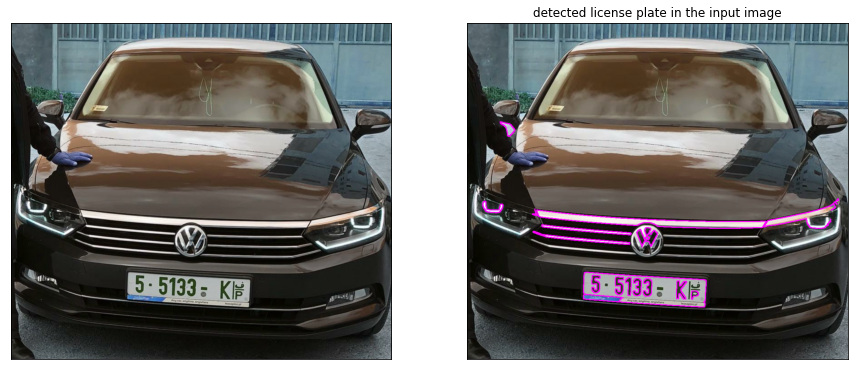

In [ ]:
plot_images(image, image_copy,'','detected license plate in the input image')

In [ ]:
plate = None
for c in cnts:
    perimeter = cv2.arcLength(c, True)
    edges_count = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(edges_count) == 4:
        x,y,w,h = cv2.boundingRect(c)
        plate = image[y:y+h, x:x+w, :]
        break

cv2.imwrite("plate.png", plate)

True

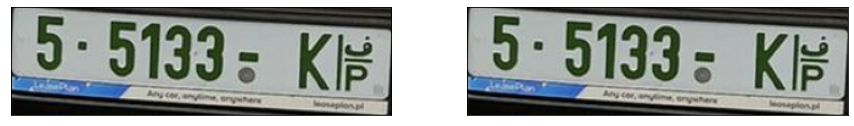

In [ ]:
plot_images(plate, plate)

# Preprocessing 

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.png')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.png',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

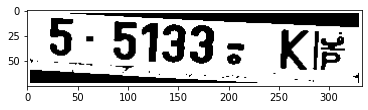

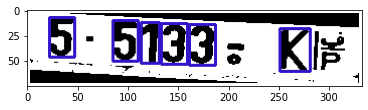

In [ ]:
# Let's see the segmented characters
char = segment_characters(plate)

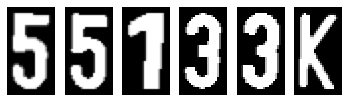

In [ ]:
for i in range(len(char[:6])):
    plt.subplot(1, 6, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

#Predicting the output

In [ ]:
#lode the model
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/data/final_version_models.h5')

In [ ]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        predict_x=model.predict(img)[0] #predicting the class 
        y_=np.argmax(predict_x,axis=0)
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

P_char=show_results()
P_char=P_char[:6]
print(P_char)

55133K


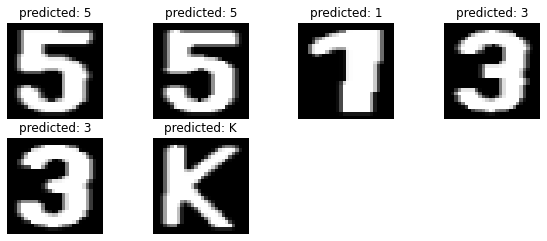

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char[:6]):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [ ]:
print(P_char)

55133K


In [ ]:
P_char

'55133K'